In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def load_data(train_path, test_path):
    """Loading training and test data from CSV files."""
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    return train_data, test_data


def check_target_column(df, target_column):
    """Checking for the presence of the target column in the data."""
    if target_column not in df.columns:
        raise ValueError(f"Column '{target_column}' not found in training data.")


def split_features_target(df, target_column):
    """Separating the target variable from features."""
    X = df.drop(columns=[target_column])
    y = df[target_column]
    return X, y


def drop_missing_columns(X, threshold=0.33):
    """Removing columns with missing values above the specified threshold."""
    non_missing_threshold = int((1 - threshold) * X.shape[0])
    return X.dropna(thresh=non_missing_threshold, axis=1)


def define_feature_types(X):
    """Defining feature types: numerical, binary categorical, and other categorical."""
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()
    binary_categorical_features = [col for col in X.select_dtypes(include=['object']).columns if X[col].nunique() == 2]
    categorical_features = [col for col in X.select_dtypes(include=['object']).columns if X[col].nunique() > 2]
    return numerical_features, binary_categorical_features, categorical_features


def create_preprocessor(numerical_features, binary_categorical_features, categorical_features):
    """Creating and applying a transformer for numerical and categorical data."""
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    binary_categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=None)),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('binary_cat', binary_categorical_transformer, binary_categorical_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    return preprocessor


def save_predictions(model, test_data, original_test_df, save_path):
    """Saving predictions to a CSV file."""
    predictions = model.predict(test_data)
    result_df = pd.DataFrame({"index": original_test_df.index, "y": predictions})
    result_df.to_csv(save_path, index=False)
    print(f"Predictions saved to file {save_path}")


# Function to visualize the distribution of numerical data
def plot_numerical_distribution(X, numerical_features):
    """Function to visualize the distribution of numerical features before and after normalization."""
    fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, len(numerical_features) * 4))
    for i, feature in enumerate(numerical_features):
        sns.histplot(X[feature], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()


# Function to visualize missing data
def plot_missing_data(X):
    """Function to visualize missing data."""
    plt.figure(figsize=(12, 8))
    sns.heatmap(X.isnull(), cbar=False, cmap='viridis')
    plt.title("Missing values in data")
    plt.show()


# Visualization of feature importances
def plot_feature_importances(model, feature_names, top_n=20):
    """Function to visualize feature importances."""
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:top_n]

    plt.figure(figsize=(10, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(top_indices)), importances[top_indices], align="center")
    plt.xticks(range(len(top_indices)), [feature_names[i] for i in top_indices], rotation=90)
    plt.tight_layout()
    plt.show()


# Function to visualize the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """Function to plot the confusion matrix."""
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title("Confusion Matrix")
    plt.show()



In [3]:
def main(train_path, test_path, target_column, save_path):
    """Main function to perform all steps of data processing, model training, and saving predictions."""

    # Loading data
    train_data, test_data = load_data(train_path, test_path)

    # Checking for the presence of the target column
    check_target_column(train_data, target_column)

    # Data preprocessing
    X, y = split_features_target(train_data, target_column)
    X = drop_missing_columns(X)
    test_data = test_data[X.columns]

    print("After dropping columns with missing values: X.shape =", X.shape)

    # Visualizing missing data
    plot_missing_data(X)

    # Defining feature types
    numerical_features, binary_categorical_features, categorical_features = define_feature_types(X)

    # Visualizing the distribution of numerical features before processing
    # plot_numerical_distribution(X, numerical_features)

    # Creating a pipeline for data processing
    preprocessor = create_preprocessor(numerical_features, binary_categorical_features, categorical_features)

    # Creating a transformer for selecting the most important features
    feature_selector = SelectFromModel(estimator=XGBClassifier(random_state=42, eval_metric='logloss'))

    # Main pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector)
    ])

    # Data transformation
    X_processed = pipeline.fit_transform(X, y)
    print("After transformation: X_processed.shape =", X_processed.shape)

    # Splitting data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

    # Modeling and evaluation
    class_weights = {0: 1, 1: len(y_train) / sum(y_train)}
    xgb_model = XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=class_weights[1],
        random_state=42,
        eval_metric='logloss'
    )

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'n_estimators': [250],
        'max_depth': [3],
        'learning_rate': [0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }

    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_xgb_model = grid_search.best_estimator_

    y_pred = best_xgb_model.predict(X_val)
    balanced_acc = balanced_accuracy_score(y_val, y_pred)
    print(f"Balanced Accuracy Score with XGBoost: {balanced_acc}")

    # Getting feature names after preprocessing
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

    # Visualizing feature importances
    plot_feature_importances(best_xgb_model, feature_names)

    # Visualizing the confusion matrix after building the model
    plot_confusion_matrix(y_val, y_pred)

    # Saving predictions
    X_test_processed = pipeline.transform(test_data)
    save_predictions(best_xgb_model, X_test_processed, test_data, save_path)

    best_params = grid_search.best_params_
    print("Optimal parameters:")
    print(best_params)



After dropping columns with missing values: X.shape = (10000, 67)


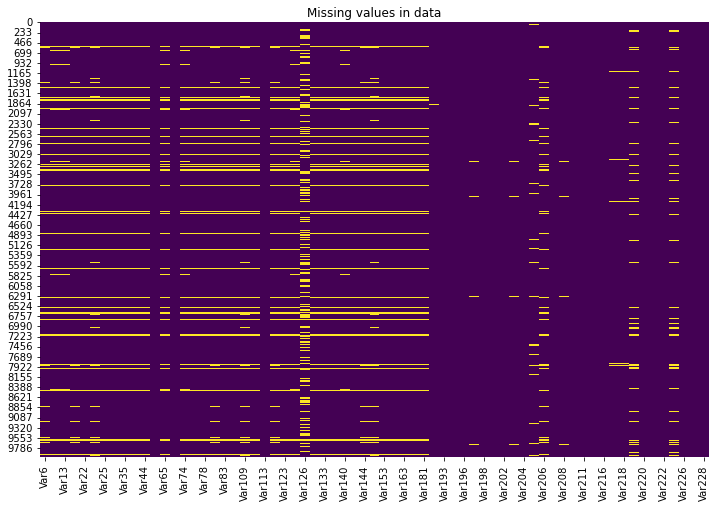

After transformation: X_processed.shape = (10000, 250)
Balanced Accuracy Score with XGBoost: 0.9001529041881207


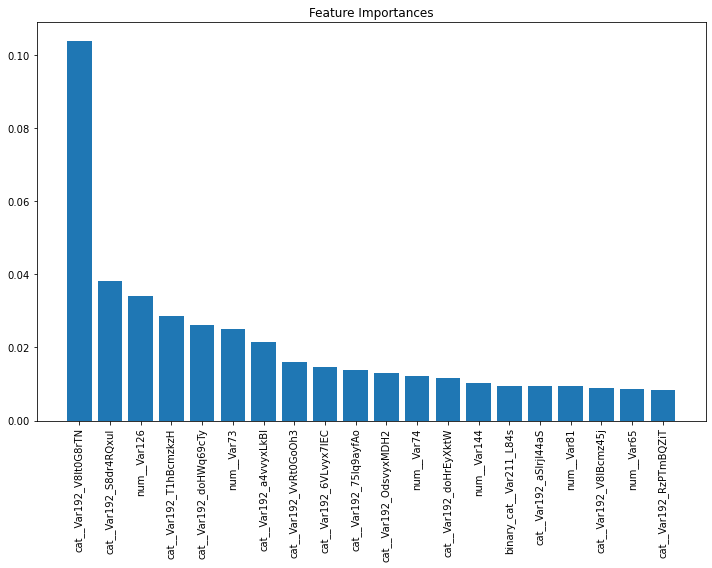

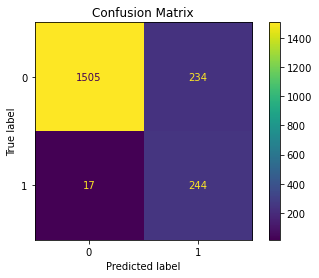

Predictions saved to file D:/00_GoIT/06_Machine-Learning/competition/Final Project/predictions_XGB_91-65.csv
Optimal parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'subsample': 0.8}


In [4]:
# Executing the main function
if __name__ == "__main__":
    main(
        train_path='D:/00_GoIT/06_Machine-Learning/competition/Final Project/final_proj_data.csv',
        test_path='D:/00_GoIT/06_Machine-Learning/competition/Final Project/final_proj_test.csv',
        target_column='y',
        save_path="D:/00_GoIT/06_Machine-Learning/competition/Final Project/predictions_XGB_91-65.csv"
    )